# NVDM

Re-adapt NVDM code for unified notebook.
The main difference is using sklearn's CountVectorizer like the other models.
Unlike the original notebook, which passes in business descriptions as variable-length sequences,
we directly pass in bag-of-words (generated using the count-vectorizer).
This results in much faster training as well.

In [1]:
import os
import string
import pathlib
import pickle
from timeit import default_timer as timer
from datetime import timedelta

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
# PyTorch stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

# Autoselect target device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [6]:
%load_ext autoreload
%autoreload 2

from models import nvdm

## Helper Functions

In this section, we provide helper function definitions.

### Preprocessing

In [7]:
# Instance of Lemmatizer
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

def preprocess_text(text):
    """ Process a single line of text. """

    # Strip trailing characters if any (e.g. newline)
    text_new = text.strip()
    
    # Remove puncuation
    text_new = ''.join(ch for ch in text_new if ch not in string.punctuation)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    text_new = ' '.join(tokens)

    return text_new

### Model Definitions

We experimented with three types of model:

- K-Means
- Latent Dirichlet Allocation (LDA)
- Neural Variational Document Modelling (NVDM)

For this demo, we only show the "best" model for each type. Please refer to the report and model-specific notebooks for details on hyperparameter selection.

In [8]:
class Model:
    """ Base class for clustering models.
    
    Basically a wrapper for a variety of models.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ Train the model. """
        raise NotImplementedError()
    
    def transform(self, X):
        """ Apply model to new data. """
        raise NotImplementedError()
    
    @property
    def topic_vocab_matrix(self):
        """ Each model should be able to return a topic-vocab matrix
        containing a score (e.g. probability) of a word in the vocabulary
        occuring in the k^th topic. """
        pass

class NVDMModel(Model):
    """ PyTorch NVDM model.
    
    Loads a pretrained model from disk.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ We don't train the model here because it takes too long. """
        pass
    
    def transform(self, X):
        pass
    
    @property
    def topic_vocab_matrix(self):
        """ Returns the learned semantic embeddings of each word. """
        decoder = self.model.decoder[0]
        weights = decoder.weight.data.detach().clone().numpy()
        return weights.T

### Evaluation

We provide functions for evaluation below.
The _topic coherence_ metric is used. TODO perplexity for LDA and NVDM.

In [9]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))[0]

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

    score_umass = np.log((Dwi_wj + 1)/ Dwi)
    
    return score_umass

def topic_coherence(topic_vocab, n_top_words, pair_score):
    """ Compute the topic coherence of each topic,
    given a learned topic-vocabulary matrix, the number of top words to use
    and a matrix of pairwise scores (e.g. umass_score output)
    
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    """ Given a topic-vocabulary matrix containing scores
    (e.g. probabilities, higher the better),
    plot the top words as a frequency bar-graph for each topic.
    
    e.g. set topic_vocab=model._components for LDA.
    """
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    fig.tight_layout()
    plt.show()

### Data-Loading

Functions for loading all business description datasets (S&P500 and bds1).

In [10]:
def load_sp500(path, preprocess=False):
    """ Load S&P500 data from the per-company text files in the supplied directory path.
    
    Within the directory, each file is named "<ticker>_<sector>.txt".
    Each contains the business description (BD) of the company.
    
    If preprocess is True, the preprocess the business descriptions at the same time.
    """
    filenames = os.listdir(path)

    tickers = []
    sectors = []
    bds = []
    for fn in filenames:
        prefix = fn.split('.txt')[0]
        ticker, sector = prefix.split('_')
        filepath = os.path.join(path, fn)
        with open(filepath, 'r', encoding="utf8") as f:
            bd = f.read().strip()
        
        if preprocess:
            bd = preprocess_text(bd)

        tickers.append(ticker)
        sectors.append(sector)
        bds.append(bd)
    
    return tickers, sectors, bds


def load_bds1(path, preprocess=False, exclude_tickers=None):
    """ Load data from the business data, given the file path (e.g. "data/bds_1.txt").
    
    In the file, each company has two consecutive lines.
    The first line is <company ticker>:<CIK> (we only care about the ticker)
    and the second line is the company business description.
    
    exclude_tickers is a list of tickers that we want to ignore in bds_1.txt.
    For example, we can use this to exclude any S&P500 companies to avoid
    overlapping of datasets.
    """
    
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()

    company_ids_all = [ln.strip() for ln in lines[0::2]]
    company_descriptions_all = [ln.strip() for ln in lines[1::2]]
    company_tickers = [x.split(':')[0] for x in company_ids_all]

    exclusion_set = set(exclude_tickers) if exclude_tickers is not None else set()

    tickers = []
    bds = []
    
    # Some business descriptions are too short (or even empty),
    # so we only keep those with a length (number of characters) deemed reasonable.
    bd_valid_length = 3000
    for ticker, bd in zip(company_tickers, company_descriptions_all):
        if ticker not in exclusion_set and len(bd) >= bd_valid_length:
            tickers.append(ticker)
            
            if preprocess:
                bd = preprocess_text(bd)
            bds.append(bd)
    
    return tickers, bds

## Begin Demo

In [11]:
%%time
# Load and preprocess S&P500 and BDS1 data.
# We use BDS1 as the training set and S&P500 as the validation set.
sp500_tickers, sp500_sectors, sp500_bds = load_sp500("../SP500", preprocess=True)
bds1_tickers, bds1_bds = load_bds1("./data/bds_1.txt", preprocess=True, exclude_tickers=sp500_tickers)

CPU times: user 1min 2s, sys: 364 ms, total: 1min 3s
Wall time: 1min 3s


In [13]:
# FEATURE EXTRACTION
# Use this to convert text to a Bag-of-Words (term-frequency) representation.
# We "train" this vectorizer on S&P500 only, assuming the BDS1 validation set is "unseen".
# When evaluating, if a word in a business description from BDS1 doesn't exist in S&P500 data,
# then it will be ignored.

# Only keep top n most frequent words (adjust futher if required)
# These parameters (except stopwords, since they are already removed)
# were used in LDA notebooks. Adjust if needed.
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2)
tf_vectorizer.fit(sp500_bds)

CountVectorizer(max_df=0.95, max_features=4000, min_df=2)

In [14]:
# Convert text from the training and test set to bag-of-words representations.
X_sp500 = tf_vectorizer.transform(sp500_bds).toarray()
X_bds = tf_vectorizer.transform(bds1_bds).toarray()

In [16]:
class BDDataset(Dataset):
    """ Very simple dataset object. Stores all the passages.
    
    This is just for compatibility with PyTorch DataLoader.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
def perplexity(model, dataset, n_sample, device="cpu"):
    """ Compute perplexity of PyTorch model on the PyTorch Dataset.
    
    If this gives a GPU/CPU error, try adding this before calling this function:
    
    model.device = "cpu"
    model = model.cpu()
    model.eval()
    """

    # Iterate over the whole dataset once (1 big batch).
    data_loader = DataLoader(dataset,
                             batch_size=len(dataset),
                             shuffle=False)
    assert len(data_loader) == 1

    for text in data_loader:
        text = text.to(device)

        with torch.no_grad():

            # Estimate the loss for each document by sampling
            loss_dict = model(text, kl_weight=1.0, n_sample=n_sample)
            loss = loss_dict["total"]

            # According to the NVDM paper, we estimate log probabilities using
            # the variational lower bound (negative of loss).
            log_probs = -loss

            # Perplexity below...
            
            # Length of each document is the sum of its bag-of-words vectpr
            doc_lengths = text.sum(dim=1)

            # Average over the words for each document
            ppx_doc = log_probs / doc_lengths

            # Perplexity: argument averages over documents
            ppx = torch.exp(-ppx_doc.mean()).item()

            return ppx

In [18]:
def train(model, data_loader, outer_epochs=1000, print_every=100, device="cpu"):

    
    def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
        """
        A cyclical rate for the KL divergence weight "beta".
        This is common practice in NLP to train VAEs.
        NOTE: this is taken from https://github.com/haofuml/cyclical_annealing's README.
        Also refer to https://arxiv.org/pdf/1903.10145.pdf for more information.
        
        Args:
            n_iter: number of epochs
            start, stop: the range of beta (should be between 0 and 1)
            n_cycle: number of cycles
            ratio: a hyperparameter R. proportion used to increase beta within a cycle, default 0.5
        Returns:
            A list containing beta values over n_iter epochs.
        """
        
        L = np.ones(n_iter) * stop
        period = n_iter / n_cycle
        step = (stop - start) / (period * ratio) # linear schedule

        for c in range(n_cycle):
            v, i = start, 0
            while v <= stop and (int(i + c * period) < n_iter):
                L[int(i + c * period)] = v
                v += step
                i += 1
        return L
    
    
    # Trains both the encoder and decoder at the same time.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    start_time = timer()
    print("Start training...")

    # Changing beta over time?
    use_cyclical_beta = True
    if use_cyclical_beta:
        betas = frange_cycle_linear(outer_epochs)
    else:
        # Constant beta = 1 (loss is equivalent to negative variational lower bound.)
        betas = np.ones(outer_epochs)

    for epoch in range(outer_epochs):

        loss_sum = 0.0
        rec_sum = 0.0
        kl_sum = 0.0
        n = len(data_loader)

        for text in data_loader:
            text = text.to(device)

            optimizer.zero_grad()
            loss_dict = model(text, kl_weight=betas[epoch])
            loss = loss_dict["total"].sum()
            loss.backward()

            optimizer.step()

            # For printing
            loss_sum += loss.item()
            rec_sum += loss_dict["rec"].sum().item()
            kl_sum += loss_dict["kl"].sum().item()

        if (epoch + 1) % print_every == 0:
            # Print training perplexity as well
            ppx = perplexity(model, data_loader.dataset, 20, device=device)
            print(f"[Time: {timedelta(seconds=timer() - start_time)}, Epoch {epoch + 1}] Loss {loss_sum/n}, Rec {rec_sum/n}, KL {kl_sum/n}, PPX {ppx}")

In [25]:
# Create data loader to iterate over dataset in batches during training/evaluation
train_dataset = BDDataset(torch.tensor(X_bds, dtype=torch.float32))
test_dataset = BDDataset(torch.tensor(X_sp500, dtype=torch.float32))
batch_size = 64
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
hidden_size = 250
num_topics = 15  # try this K for demonstration
vocab_size = len(tf_vectorizer.get_feature_names())

In [53]:
model = nvdm.NVDM(vocab_size, hidden_size, num_topics, 1, device)
model = model.to(device)
model.train()
num_epochs = 150
train(model, train_data_loader, outer_epochs=num_epochs, print_every=int(num_epochs/4), device=device)

Start training...
[Time: 0:00:02.979396, Epoch 37] Loss 1973668.3166666667, Rec 1969518.7125, KL 4149.61767578125, PPX 1238.4287109375
[Time: 0:00:05.934118, Epoch 74] Loss 1951593.0, Rec 1947524.26875, KL 4068.734138997396, PPX 1133.35498046875
[Time: 0:00:08.891090, Epoch 111] Loss 1942833.0708333333, Rec 1938833.4666666666, KL 3999.5900024414063, PPX 1092.85107421875
[Time: 0:00:11.841936, Epoch 148] Loss 1939045.375, Rec 1935136.0875, KL 3909.2900634765624, PPX 1076.2620849609375


In [54]:
# Compute perplexity example
model.device = "cpu"
model = model.cpu()
model.eval()

# Perplexity (train and test)
ppx_train = perplexity(model, train_dataset, 20)
ppx_test = perplexity(model, test_dataset, 20)
print(ppx_train, ppx_test)

1075.5316162109375 1670.05029296875


In [55]:
# Extract the vocab-topic matrix (known as R in the paper).
# It has dimensions |V| x K: vocab size x number of topics
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone()
weights.size()

torch.Size([4000, 15])

In [56]:
# Look at some example words and their "nearest" words
# according to their learned semantic word embeddings.
candidates = ["medical", "technology", "mining"]

# Convert string tokens to their integer ID and vice versa.
stoi = tf_vectorizer.vocabulary_
itos = tf_vectorizer.get_feature_names()

for test_word in candidates:
    idx = stoi[test_word]
    print(test_word, idx)

    # Show top most similar (based on cosine distance)
    sims = F.cosine_similarity(weights[idx].unsqueeze(0), weights)
    sim_vals, sim_idxs = torch.topk(sims, 15)

    # Show ith nearest word and its score.
    for i, v in zip(sim_idxs, sim_vals):
        print(f"{itos[i]}\t{v.item()}")
    
    print("-----------")

medical 2369
medical	1.0
hospital	0.783384382724762
healthcare	0.7674558162689209
care	0.7639763355255127
physician	0.730999767780304
patient	0.7282289266586304
injury	0.713577389717102
reimbursement	0.691039502620697
health	0.6879773736000061
device	0.6579040884971619
imaging	0.6523977518081665
medicare	0.6510509252548218
fda	0.6394781470298767
surgery	0.6375811696052551
marketed	0.6128922700881958
-----------
technology 3652
technology	1.0
proprietary	0.9125967621803284
use	0.8593741655349731
key	0.8488572239875793
support	0.8437989354133606
large	0.8416608572006226
continue	0.8382390737533569
effort	0.8363791108131409
research	0.8360199928283691
design	0.8343160152435303
system	0.8263705968856812
many	0.8263605237007141
designed	0.8105342984199524
process	0.807824969291687
need	0.807421088218689
-----------
mining 2425
mining	1.0
mine	0.9012989401817322
flat	0.757916271686554
road	0.7326862812042236
ore	0.70769864320755
wyoming	0.7000043392181396
coal	0.693590521812439
creek	0.69050

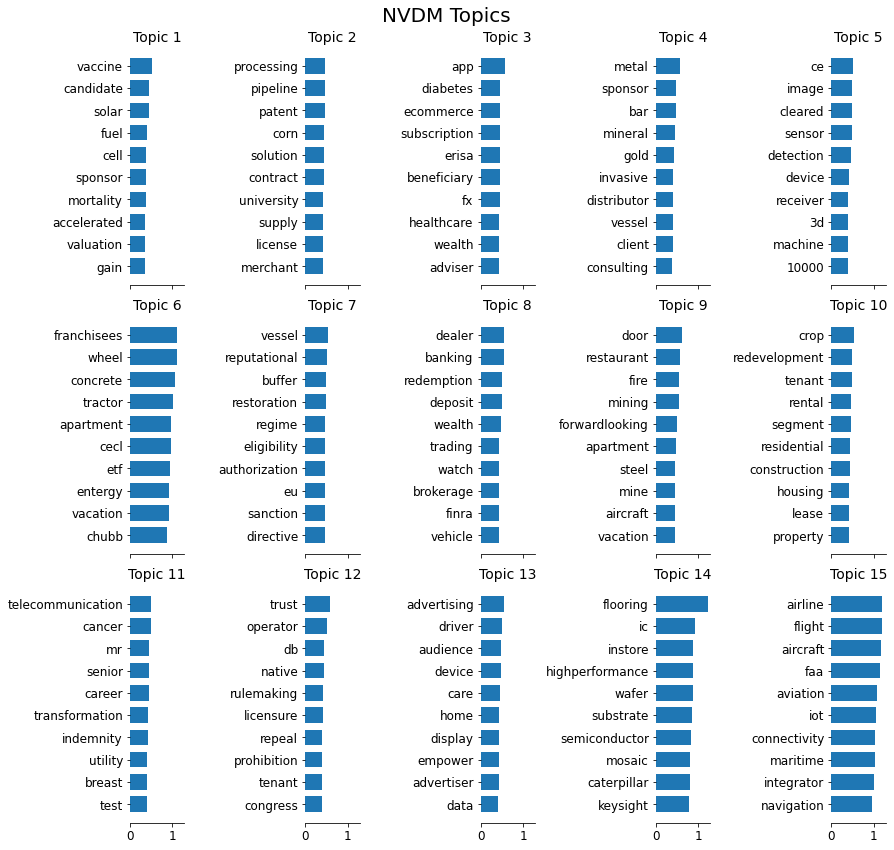

In [57]:
# For each of the topics, plot its most "relevant" words.
# Relevance is determined by the weight matrix R in the model's decoder.
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone().cpu().numpy()
topic_vocab_mat = weights.T

plot_top_words(topic_vocab_mat, tf_vectorizer.get_feature_names(), 10, f"NVDM Topics")

Instead of the decoder's semantic embedding matrix, we look at the encoder's latent outputs directly:

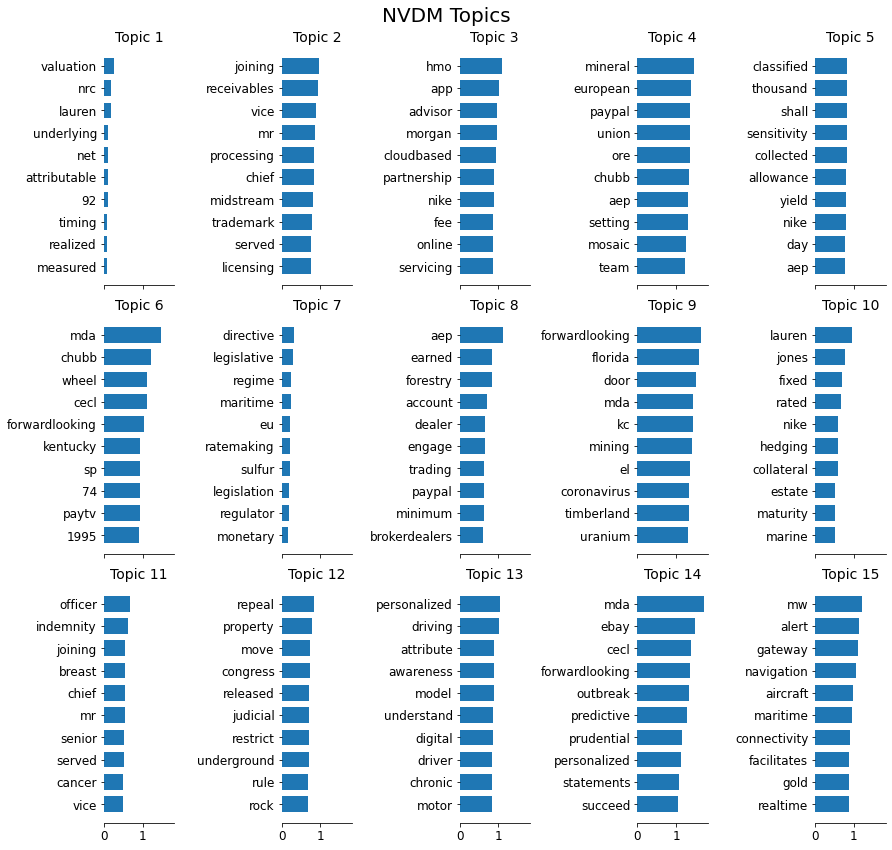

In [58]:
with torch.no_grad():
    # Generate a latent representation for each word in the vocabulary,
    # passing in each word in the vocabulary as a one-hot vector.
    _, tmp, _ = model.encode(torch.eye(n=vocab_size))
    tmp = tmp.numpy().T
    plot_top_words(tmp, tf_vectorizer.get_feature_names(), 10, f"NVDM Topics")

## Trying different values of K on BDS1

Here we look at two metrics: topic coherence (using UMass pairwise scores) and perplexity.

In [59]:
%%time
# Used for topic coherence
# UMass pairwise score metric.
# This takes a long time for some reason, even thought it is just matrix multiplication etc. operations
score_umass_mat_bds = umass_score(X_bds)
score_umass_mat_sp500 = umass_score(X_sp500)

CPU times: user 2min, sys: 104 ms, total: 2min
Wall time: 2min


In [60]:
# Try various number of topics K
# k_values = [10, 50, 100, 150, 200, 300, 500]
k_values = [10, 20, 30, 40, 50, 75, 100]
models_k = dict()
vocab_size = len(tf_vectorizer.get_feature_names())

hidden_size = 250
num_epochs = 150

for k in k_values:
    print(f"Training k={k}...")
    model_k = nvdm.NVDM(vocab_size, hidden_size, k, 1, device)
    model_k = model_k.to(device)
    model_k.train()
    train(model_k, train_data_loader, outer_epochs=num_epochs, print_every=int(num_epochs), device=device)
    models_k[k] = model_k

Training k=10...
Start training...
[Time: 0:00:12.640015, Epoch 150] Loss 1952460.9666666666, Rec 1949245.2333333334, KL 3215.7179280598957, PPX 1138.6846923828125
Training k=20...
Start training...
[Time: 0:00:12.549181, Epoch 150] Loss 1929581.8708333333, Rec 1925002.4979166666, KL 4579.385237630208, PPX 1033.6812744140625
Training k=30...
Start training...
[Time: 0:00:12.293079, Epoch 150] Loss 1920316.5604166666, Rec 1914661.2083333333, KL 5655.407576497396, PPX 992.3311157226562
Training k=40...
Start training...
[Time: 0:00:12.581191, Epoch 150] Loss 1915765.7333333334, Rec 1909181.3958333333, KL 6584.336751302083, PPX 974.3508911132812
Training k=50...
Start training...
[Time: 0:00:12.872619, Epoch 150] Loss 1912078.6875, Rec 1904617.9166666667, KL 7460.782047526041, PPX 956.1903076171875
Training k=75...
Start training...
[Time: 0:00:12.866645, Epoch 150] Loss 1907753.4416666667, Rec 1898434.3791666667, KL 9319.08212890625, PPX 940.983642578125
Training k=100...
Start training.

In [70]:
# For each K, compute topic coherence and perplexity on the training and test set.
k_values.sort()
tc_values_train = []
tc_values_test = []
ppx_values_train = []
ppx_values_test = []

for k in k_values:
    print(f'Running k = {k}')
    this_model = models_k[k]
    
    this_model.device = "cpu"
    this_model = this_model.cpu()
    this_model.eval()
    
    # Extract the topic vocab matrix
    decoder = this_model.decoder[0]
    weights = decoder.weight.data.detach().clone().cpu().numpy()
    topic_vocab_mat = weights.T
    
#     with torch.no_grad():
#         # Generate a latent representation for each word in the vocabulary,
#         # passing in each word in the vocabulary as a one-hot vector.
#         _, tmp, _ = this_model.encode(torch.eye(n=vocab_size))
#         topic_vocab_mat = tmp.numpy().T
    
    # Topic coherence
    coherences_train = topic_coherence(topic_vocab_mat, 10, score_umass_mat_bds)
    tc_values_train.append(np.mean(coherences_train))
    
    coherences_test = topic_coherence(topic_vocab_mat, 10, score_umass_mat_sp500)
    tc_values_test.append(np.mean(coherences_test))
    
    # Perplexity
    ppx_train = perplexity(this_model, train_dataset, 20)
    ppx_test = perplexity(this_model, test_dataset, 20)
    ppx_values_train.append(ppx_train)
    ppx_values_test.append(ppx_test)

Running k = 10
Running k = 20
Running k = 30
Running k = 40
Running k = 50
Running k = 75
Running k = 100


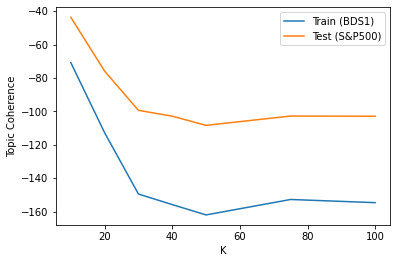

In [71]:
plt.plot(k_values, tc_values_train, label="Train (BDS1)")
plt.plot(k_values, tc_values_test, label="Test (S&P500)")
plt.xlabel("K")
plt.ylabel("Topic Coherence")
plt.legend();

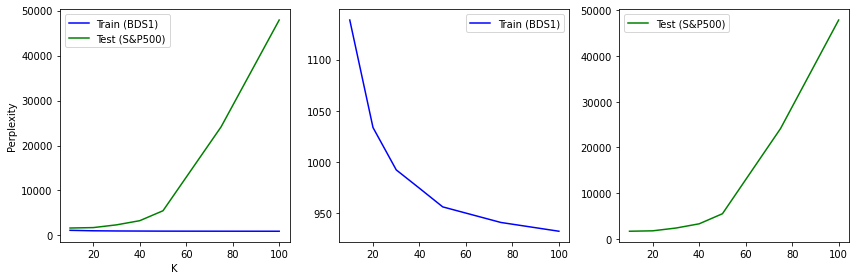

In [72]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
axs[0].plot(k_values, ppx_values_train, label="Train (BDS1)", color="b")
axs[0].plot(k_values, ppx_values_test, label="Test (S&P500)", color="g")
axs[0].set_xlabel("K")
axs[0].set_ylabel("Perplexity")
axs[0].legend();

axs[1].plot(k_values, ppx_values_train, label="Train (BDS1)", color="b")
axs[1].legend()
axs[2].plot(k_values, ppx_values_test, label="Test (S&P500)", color="g")
axs[2].legend()
plt.tight_layout();

In [110]:
# Ideally, choose the model with the best balance between topic coherence and perplexity.
# Then uncomment the code below to save it to disk.

# MODELSAVE_PATH = "./modelsaves/nvdm_k300_1000epochs.pt"
# torch.save(models_k[300].state_dict(), MODELSAVE_PATH)

# Check the perplexity again, just to make sure that the test perplexity doesn't explode.
# ppx_train = perplexity(model, train_dataset, 20)
# ppx_test = perplexity(model, test_dataset, 20)
# print(ppx_train, ppx_test)

# Retrain if needed below
# best_model = nvdm.NVDM(vocab_size, hidden_size, 300, 1, device)
# best_model = best_model.to(device)
# best_model.train()
# train(best_model, data_loader, outer_epochs=1000, print_every=200, device=device)

## Visualizing Semantic Embeddings

T-SNE Experiments

In [97]:
# Plot T-SNE of learnt semantic embeddings
# The authors of NVDM also do this

from sklearn.manifold import TSNE

# Extract the learned semantic embedding matrix from the decoder
# (denoted R in the original paper)
# This is a vocab_size x num_topics matrix.
# Each word in the vocabulary is embedded into a vector with dimension equal to the number of topics.
model = nvdm.NVDM(vocab_size, hidden_size, 300, 1, "cpu")
model.load_state_dict(torch.load("./modelsaves/nvdm_k300_1000epochs.pt", map_location="cpu"))
model.eval()
decoder = model.decoder[0]
weights = decoder.weight.data.detach().clone().cpu().numpy()
topic_vocab = weights
topic_vocab.shape

(4000, 300)

In [100]:
%%time
# Visualise learnt semantic word embeddings in the decoder.
tsne = TSNE(
    n_components=2,
    init='random',
    random_state=1234,
    perplexity=30.0,
    n_iter=5000,
    metric='cosine',
    square_distances=True)
Y = tsne.fit_transform(topic_vocab)

CPU times: user 6min 32s, sys: 1.31 s, total: 6min 34s
Wall time: 33.4 s


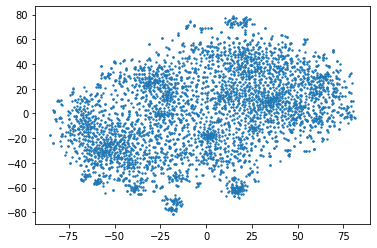

In [101]:
plt.scatter(Y[:, 0], Y[:, 1], s=2)

In [102]:
%%time

# Document embeddings using learnt semantic word vectors from the decoder
# doc_embs = X_sp500 @ topic_vocab

# Document embeddings using latent Gaussian means from the encoder
with torch.no_grad():
    _, doc_embs, _ = model.encode(test_dataset.data)
    doc_embs = doc_embs.numpy()

tsne = TSNE(
    n_components=2,
    init='random',
    random_state=1234,
    perplexity=50.0,
    n_iter=5000,
    metric='cosine',
    square_distances=True)
Y = tsne.fit_transform(doc_embs)

CPU times: user 11.1 s, sys: 696 ms, total: 11.8 s
Wall time: 999 ms


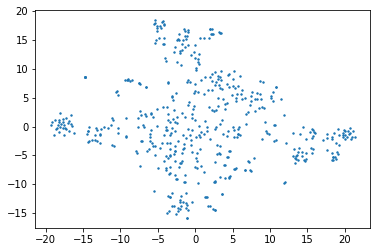

In [103]:
plt.scatter(Y[:, 0], Y[:, 1], s=2)

In [104]:
tsne_ppxs = [10, 30, 50, 100]
tsne_res = []
for i in range(4):
    print(f"Doing ppx={tsne_ppxs[i]}...")
    tsne = TSNE(
        n_components=2,
        init='random',
        random_state=1234,
        perplexity=tsne_ppxs[i],
        n_iter=5000,
        metric='cosine',
        square_distances=True)
    Y = tsne.fit_transform(doc_embs)
    tsne_res.append(Y)

Doing ppx=10...
Doing ppx=30...
Doing ppx=50...
Doing ppx=100...


In [105]:
# Convert the actual industrial sector of each company into indices
# so that we can plot different colours for each one.
# NOTE: this only applies to S&P500 data, because we don't have industry labels for BDS1.
unique_sectors = set(sp500_sectors)
sector_idx = dict(zip(unique_sectors, range(len(unique_sectors))))
sectors = [sector_idx[sec] for sec in sp500_sectors]

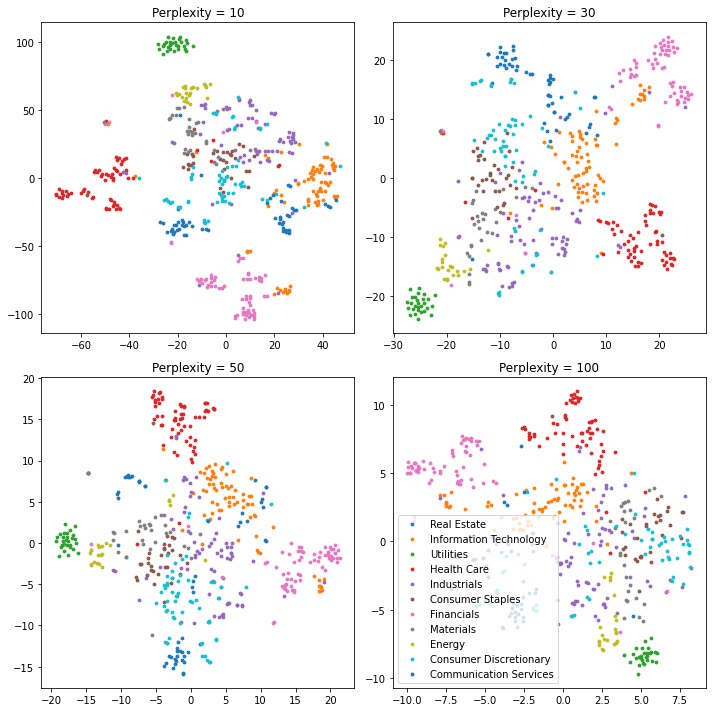

In [106]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axs = axs.flatten()

for i in range(4):
    this_ax = axs[i]
    Y = tsne_res[i]
    
    this_ax.set_title(f"Perplexity = {tsne_ppxs[i]}")
    labels = np.array(sectors)
    for sector in unique_sectors:
        this_Y = Y[labels == sector_idx[sector]]
        this_ax.scatter(this_Y[:, 0], this_Y[:, 1], s=8, label=sector)

this_ax.legend()
plt.tight_layout()

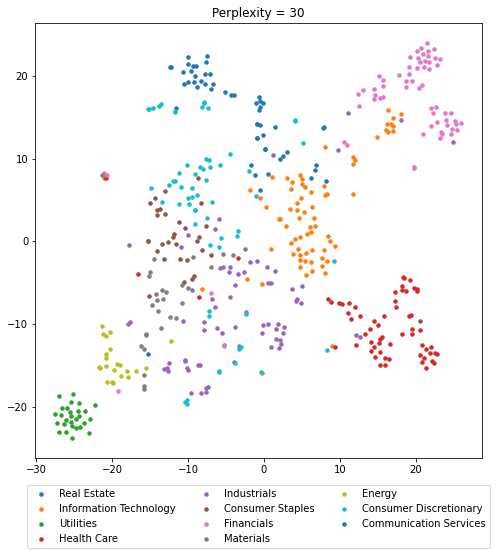

In [109]:
# Plot with perplexity 30
fig, ax = plt.subplots(figsize=(8, 8))
    
ax.set_title(f"Perplexity = {tsne_ppxs[1]}")
this_Y = tsne_res[1]
for sector in unique_sectors:
    sect_Y = this_Y[labels == sector_idx[sector]]
    ax.scatter(sect_Y[:, 0], sect_Y[:, 1], s=12, label=sector)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=3)